In [1]:
%load_ext autoreload
%autoreload 2

In [107]:
import pandas as pd
import itertools
from mbi import (
    Dataset,
    FactoredInference,
    Domain,
)
from scipy import sparse
from matplotlib import pyplot as plt

In [78]:
games = pd.read_csv("games.csv")
games["homeWin"] = (games.homeFinalScore >= games.visitorFinalScore).astype(int)
TEAMS = sorted(set(games.homeTeamAbbr).union(set(games.visitorTeamAbbr)))
print(TEAMS)
encoding = {i: j for j, i in enumerate(TEAMS)}
decoding = {j: i for j, i in enumerate(TEAMS)}
games["visitor"] = games.visitorTeamAbbr.map(lambda x: encoding[x])
games["home"] = games.homeTeamAbbr.map(lambda x: encoding[x])
COLUMNS = ["visitor", "home", "homeFinalScore", "visitorFinalScore"]
df = games[COLUMNS]
df.head()

['ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL', 'DEN', 'DET', 'GB', 'HOU', 'IND', 'JAC', 'KC', 'LAC', 'LAR', 'LV', 'MIA', 'MIN', 'NE', 'NO', 'NYG', 'NYJ', 'PHI', 'PIT', 'SEA', 'SF', 'TB', 'TEN', 'WAS']


,visitor,home,homeFinalScore,visitorFinalScore
0,10,15,20,21
1,29,20,17,20
2,30,22,16,15
3,4,1,24,10
4,12,2,25,9


In [76]:
domain = Domain(df.columns, [32, 32, 71, 71])
data = Dataset(df=df, domain=domain)
total = data.df.shape[0]

In [81]:
cliques = list(
    itertools.chain.from_iterable(
        [list(itertools.combinations(COLUMNS, i)) for i in range(1, 5)]
    )
)
cliques

[('visitor',),
 ('home',),
 ('homeFinalScore',),
 ('visitorFinalScore',),
 ('visitor', 'home'),
 ('visitor', 'homeFinalScore'),
 ('visitor', 'visitorFinalScore'),
 ('home', 'homeFinalScore'),
 ('home', 'visitorFinalScore'),
 ('homeFinalScore', 'visitorFinalScore'),
 ('visitor', 'home', 'homeFinalScore'),
 ('visitor', 'home', 'visitorFinalScore'),
 ('visitor', 'homeFinalScore', 'visitorFinalScore'),
 ('home', 'homeFinalScore', 'visitorFinalScore'),
 ('visitor', 'home', 'homeFinalScore', 'visitorFinalScore')]

In [82]:
measurements = []
for cl in cliques:
    x = data.project(cl).datavector()
    I = sparse.eye(x.size)
    measurements.append((I, x, 1.0, cl))

In [86]:
engine = FactoredInference(domain, log=True, iters=300)

In [128]:
%%time
model = engine.estimate(measurements, total=total)

Total clique size: 5161984
iteration		time		l1_loss		l2_loss		feasibility
0.00		0.00		6420.16		3906.50		0.00
50.00		25.68		465.28		12.77		0.00
100.00		53.74		161.96		1.49		0.00
150.00		79.45		96.86		0.54		0.00
200.00		104.31		68.93		0.28		0.00
250.00		129.79		53.75		0.17		0.00
CPU times: user 1min 49s, sys: 44.4 s, total: 2min 33s
Wall time: 2min 35s


In [131]:
model.domain

Domain(visitor: 32, home: 32, homeFinalScore: 71, visitorFinalScore: 71)

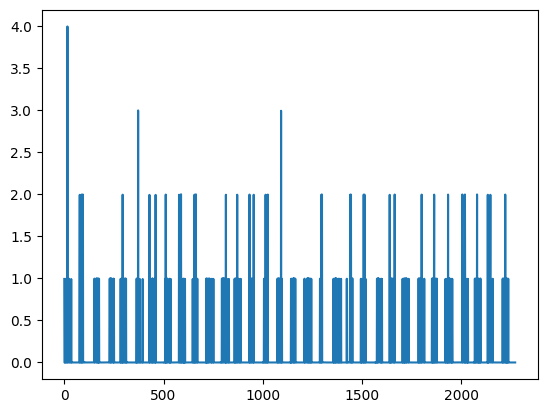

In [142]:
plt.plot(model.project(attrs=("visitor", "visitorFinalScore")).datavector())

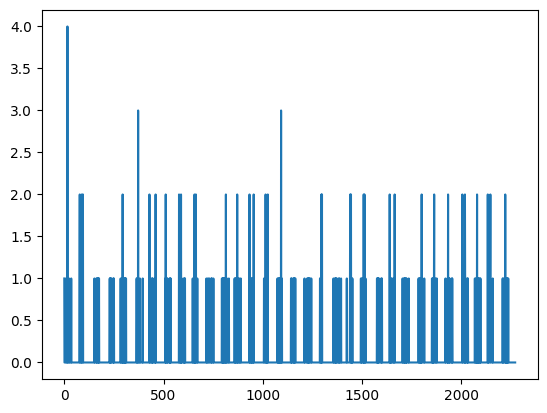

In [143]:
plt.plot(data.project(cols=(("visitor", "visitorFinalScore"))).datavector())

In [130]:
df_synthetic = model.synthetic_data(10_000_000).df

In [93]:
df_synthetic["visitorTeamAbbr"] = df_synthetic.visitor.map(lambda x: decoding[x])
df_synthetic["homeTeamAbbr"] = df_synthetic.home.map(lambda x: decoding[x])
df_synthetic["homeWin"] = df_synthetic.homeFinalScore >= df_synthetic.visitorFinalScore

In [127]:
df_synthetic.head(10)

,visitor,home,homeFinalScore,visitorFinalScore,visitorTeamAbbr,homeTeamAbbr,homeWin
0,7,2,31,33,CLE,BAL,False
1,12,6,27,30,HOU,CIN,False
2,24,7,37,20,NYJ,CLE,True
3,9,10,42,17,DEN,DET,True
4,14,30,28,20,JAC,TEN,True
5,30,29,20,6,TEN,TB,True
6,26,6,10,7,PIT,CIN,True
7,30,13,23,16,TEN,IND,True
8,1,22,48,17,ATL,NO,True
9,22,1,24,15,NO,ATL,True


In [126]:
def filter_df(df: pd.DataFrame, home: str, visitor: str) -> pd.DataFrame:
    return df.loc[(df.visitorTeamAbbr == visitor) & (df.homeTeamAbbr == home)]


def get_games(games: pd.DataFrame, team_1: str, team_2: str) -> pd.DataFrame:
    return games.loc[
        (games.homeTeamAbbr == team_1) & (games.visitorTeamAbbr == team_2)
        | (games.homeTeamAbbr == team_2) & (games.visitorTeamAbbr == team_1)
    ]


def game_counts(df: pd.DataFrame) -> pd.DataFrame:
    counts = (
        df.groupby(["homeFinalScore", "visitorFinalScore"])
        .homeTeamAbbr.count()
        .reset_index()
        .rename({"homeTeamAbbr": "count"}, axis=1)
        .sort_values(by="count", ascending=False)
        .reset_index(drop=True)
    )
    counts["percentage"] = counts["count"] / counts["count"].sum()
    return counts


def plot_home_visitor_scores(df: pd.DataFrame) -> None:
    plt.figure(figsize=(10, 4))
    plt.scatter(
        x=df.homeFinalScore,
        y=df.visitorFinalScore,
        c=df.percentage,
        s=3,
        cmap="plasma",
        alpha=0.7,
        marker="s",
        label="Simulated",
    )
    plt.ylabel("Home Team Score")
    plt.xlabel("Visitor Team Score")
    plt.plot(
        df.homeFinalScore,
        df.homeFinalScore,
        "r-",
        label="Home Score = Visitor Score",
    )
    plt.colorbar()
    plt.legend()
    plt.show()

In [123]:
get_games(games=games, team_1="KC", team_2="BAL")

,date,visitorTeam,visitorTeamAbbr,visitorFinalScore,homeTeam,homeTeamAbbr,homeFinalScore,homeWin,visitor,home


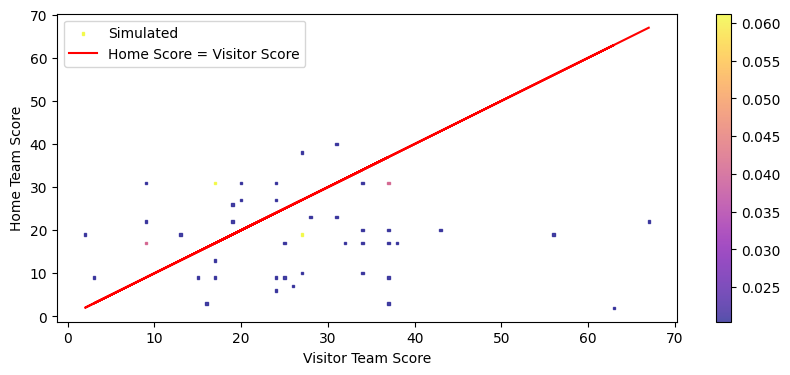

In [121]:
bal_kc_counts = game_counts(filter_df(df=df_synthetic, home="BAL", visitor="KC"))
plot_home_visitor_scores(bal_kc_counts)

In [124]:
bal_kc_counts.head(10)

,homeFinalScore,visitorFinalScore,count,percentage
0,17,31,3,0.061224
1,27,19,3,0.061224
2,9,17,2,0.040816
3,37,31,2,0.040816
4,2,19,1,0.020408
5,34,31,1,0.020408
6,28,23,1,0.020408
7,31,23,1,0.020408
8,31,40,1,0.020408
9,32,17,1,0.020408


In [116]:
get_games(games=games, team_1="SF", team_2="DET")

,date,visitorTeam,visitorTeamAbbr,visitorFinalScore,homeTeam,homeTeamAbbr,homeFinalScore,homeWin,visitor,home


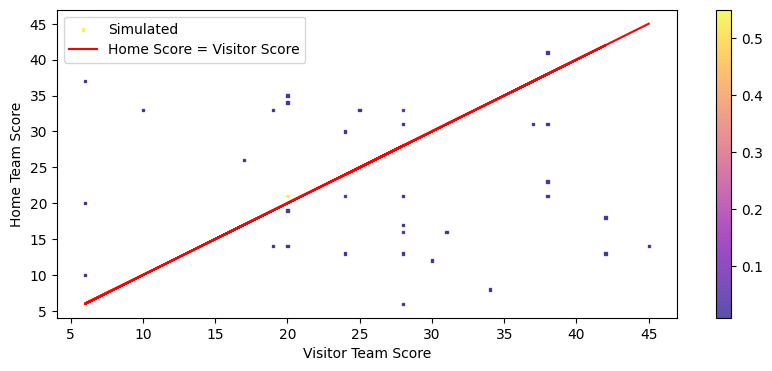

In [119]:
sf_det_counts = game_counts(filter_df(df=df_synthetic, home="SF", visitor="DET"))
plot_home_visitor_scores(sf_det_counts)

In [125]:
sf_det_counts.head(10)

,homeFinalScore,visitorFinalScore,count,percentage
0,20,21,55,0.55
1,28,33,6,0.06
2,24,21,4,0.04
3,28,16,4,0.04
4,20,19,2,0.02
5,38,41,1,0.01
6,38,31,1,0.01
7,38,23,1,0.01
8,38,21,1,0.01
9,28,17,1,0.01
